# Audio classification
### AGE (Kids/Adult/Older)

## Setting

In [10]:
import os
import numpy as np
import torch
from torch import nn

import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

device = torch.device("cuda:0")

In [2]:
import glob
import pandas as pd

train_df=pd.read_csv("C:\\Users\\USER\\Desktop\\speech-classification\\age_Dataset\\train_df.csv")
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df=pd.read_csv("C:\\Users\\USER\\Desktop\\speech-classification\\age_Dataset\\test_df.csv")
test_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df.head(5)

,audio_path,age,gender
0,D:\ksponspeech\자유대화 음성(노인남녀)\Validation\audio\...,2.0,0.0
1,"D:\ksponspeech\자유대화 음성(소아, 유아)\Validation\audi...",0.0,0.0
2,"D:\ksponspeech\자유대화 음성(소아, 유아)\Validation\audi...",0.0,0.0
3,"D:\ksponspeech\자유대화 음성(소아, 유아)\Validation\audi...",0.0,0.0
4,D:\ksponspeech\자유대화 음성(일반남녀)\Validation\audio\...,1.0,0.0


In [5]:
train_audio_path_list = list(train_df['audio_path'])[:12000]
train_age_list = list(train_df['age'])[:12000]
train_gender_list = list(train_df['gender'])[:12000]
test_audio_path_list = list(test_df['audio_path'])[:1500]
test_age_list = list(test_df['age'])[:1500]
test_gender_list = list(test_df['gender'])[:1500]

## Audio 파일 읽어오기

In [19]:
del train_audio
del test_audio

In [55]:
train_audio = []
print("train_audio START!")
for i in tqdm(range(len(train_audio_path_list))):
    try: 
        midia_file = train_audio_path_list[i]
        y, sr = librosa.load(midia_file, sr=16000) #길이는 임의로 1초로 함.
        train_audio.append(y)
    except:
        print("missing 1 file")
        print(i)
        continue
# In train_audio_path, 9708th file ocurred error because that pcm file    
test_audio = []
print("test_audio START!")
for i in tqdm(range(len(test_audio_path_list))):
    try: 
        midia_file = test_audio_path_list[i]
        y, sr = librosa.load(midia_file, sr=16000)
        test_audio.append(y)
    except:
        print("missing 1 file")
        continue

train_audio START!


 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                     | 9680/12000 [00:05<00:01, 1925.60it/s]C:\Users\USER\anaconda3\envs\kspeech4\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                   | 9873/12000 [00:05<00:01, 1671.88it/s]

missing 1 file
9708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:06<00:00, 1888.39it/s]


test_audio START!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 1763.12it/s]


In [28]:
print(train_audio[1].shape) #check audio data shape
print(type(train_audio[0]))

(68000,)
<class 'numpy.ndarray'>


## DATA padding

In [25]:
train_audio_size = [x.shape[0] for x in train_audio]
print("train_size minimum: ", np.min(train_audio_size))
print("train_size Maximum: ", np.max(train_audio_size))
print("train_size mean: ", np.mean(train_audio_size))

test_audio_size = [x.shape[0] for x in test_audio]
print("test_size minimum: ", np.min(test_audio_size))
print("test_size Maximum: ", np.max(test_audio_size))
print("test_size mean: ", np.mean(test_audio_size))

train_size minimum:  12285
train_size Maximum:  273432
train_size mean:  78863.69555796316
test_size minimum:  15015
test_size Maximum:  240240
test_size mean:  81911.16


In [42]:
# Set all training data sizes to 78000.
pre_train_audio = []
for i in train_audio:
    if i.shape[0]>78000:
        tmp = i[:78000]
    elif i.shape[0]<78000:
        tmp = np.pad(i, (0, 78000-i.shape[0]), 'constant', constant_values=0)
    elif i.shape[0]==78000:
        tmp = i
    else:
        print("ERROR!")
        print(i.shape)
        print(i)
    pre_train_audio.append(tmp)

pre_test_audio = []
for i in test_audio:
    if i.shape[0]>78000:
        tmp = i[:78000]
    elif i.shape[0]<78000:
        tmp = np.pad(i, (0, 78000-i.shape[0]), 'constant', constant_values=0)
    elif i.shape[0]==78000:
        tmp = i
    else:
        print("ERROR!")
        print(i.shape)
        print(i)
    pre_test_audio.append(tmp)

In [43]:
pre_train_audio[:5]

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([6.1035156e-05, 6.1035156e-05, 2.1362305e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([0.        , 0.        , 0.        , ..., 0.620697  , 0.5675659 ,
        0.33261108], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

In [66]:
train_labels = train_age_list
train_labels = train_labels[:9707]+train_labels[9708:] #9708th file is error file
len(train_labels)

11999

In [68]:
train_audio_np = np.array(pre_train_audio)
train_labels_np = np.array(train_labels, np.int16)
test_audio_np = np.array(pre_test_audio, np.float32)
test_labels_np = np.array(test_age_list, np.int16)

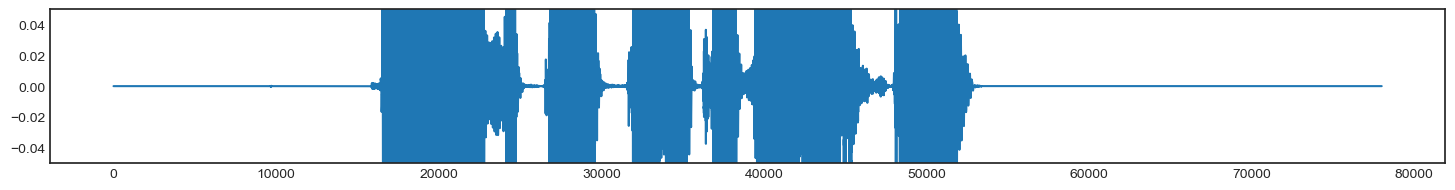

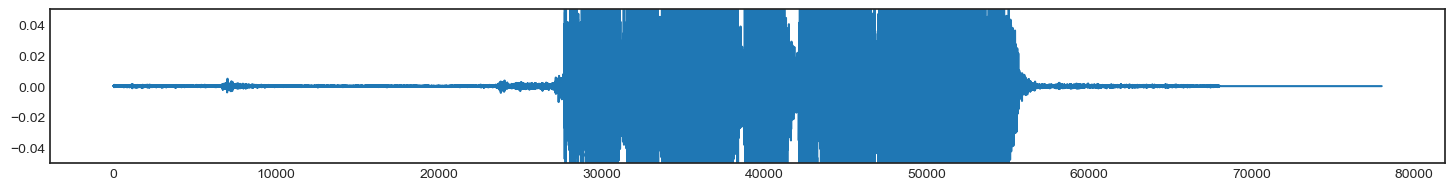

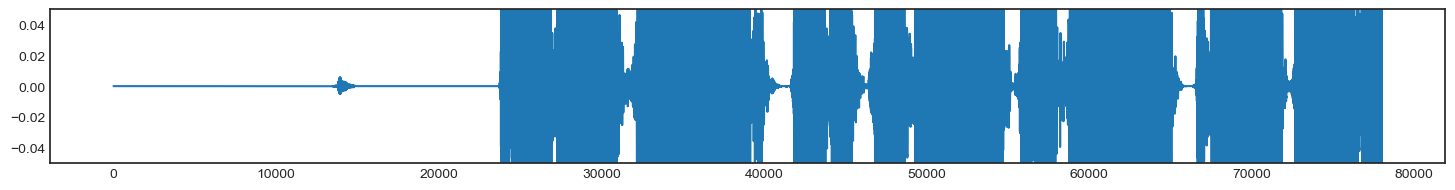

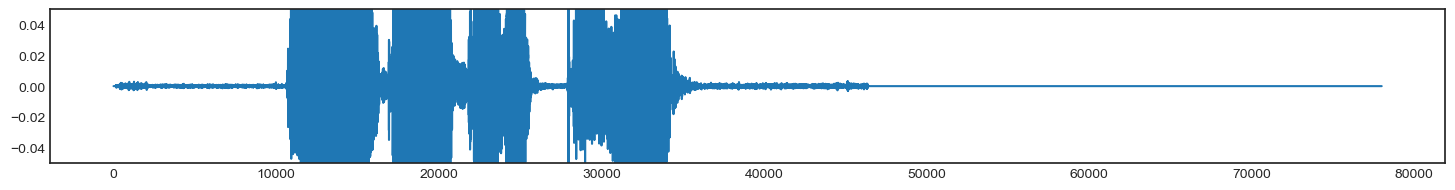

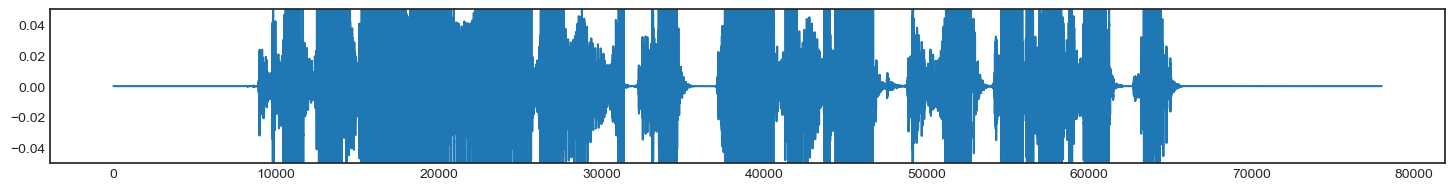

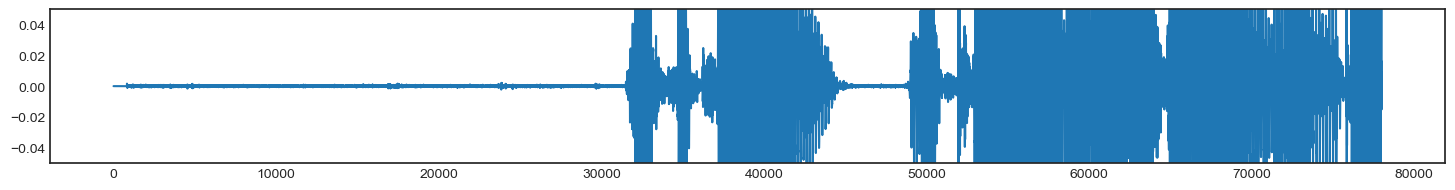

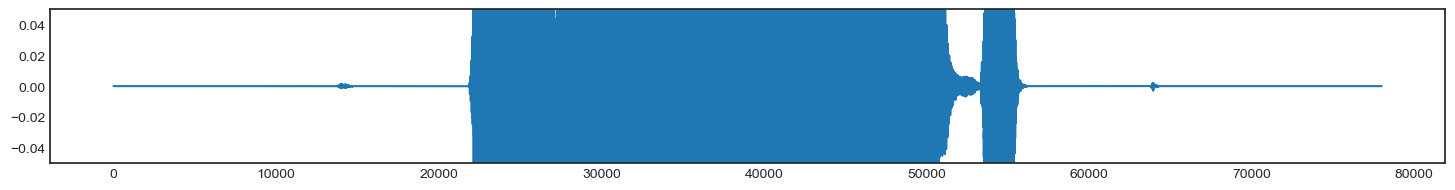

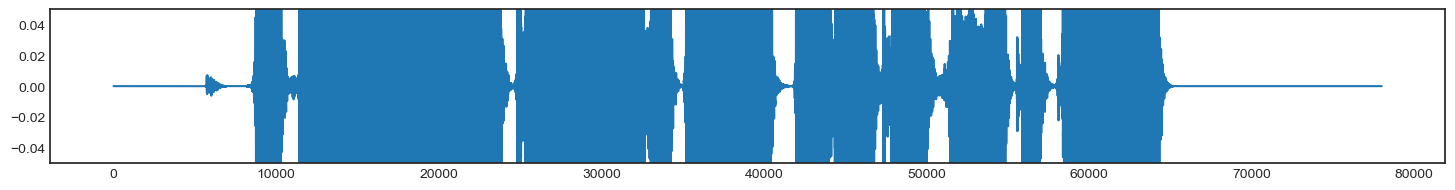

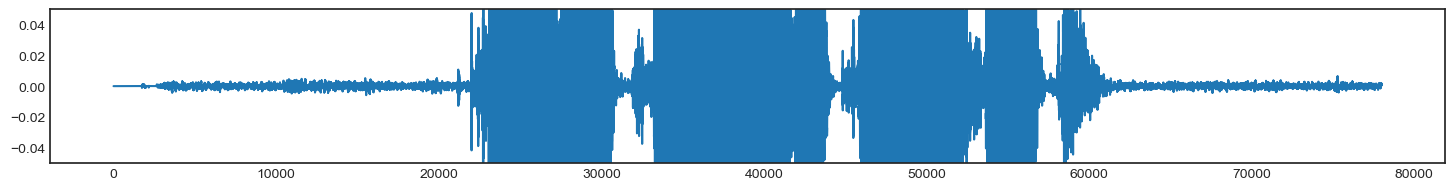

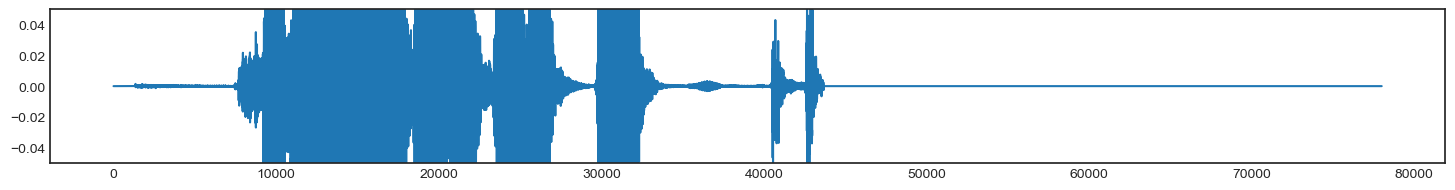

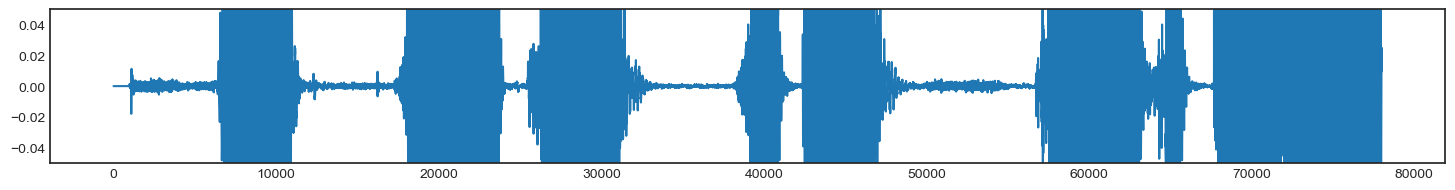

In [46]:
for idx in range(0, len(train_audio_np)):
    plt.figure(figsize=(18,2))
    plt.plot(train_audio_np[idx])
    plt.ylim((-0.05, 0.05))
    plt.show
    if idx==10: break

In [48]:
print(train_labels_np[1])
ipd.Audio(train_audio_np[1], rate=sr)

0


## Convert np array to MFCC

In [49]:
train_mfcc = []
for y in train_audio_np:
    ret = librosa.feature.mfcc(y=y, sr=sr)
    train_mfcc.append(ret)

test_mfcc = []
for y in test_audio_np:
    ret = librosa.feature.mfcc(y=y, sr=sr)
    test_mfcc.append(ret)

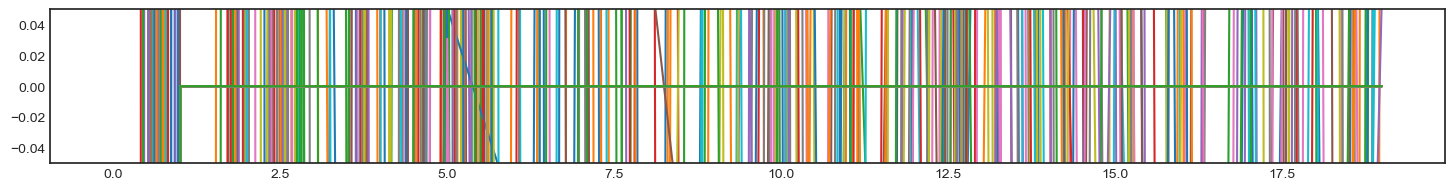

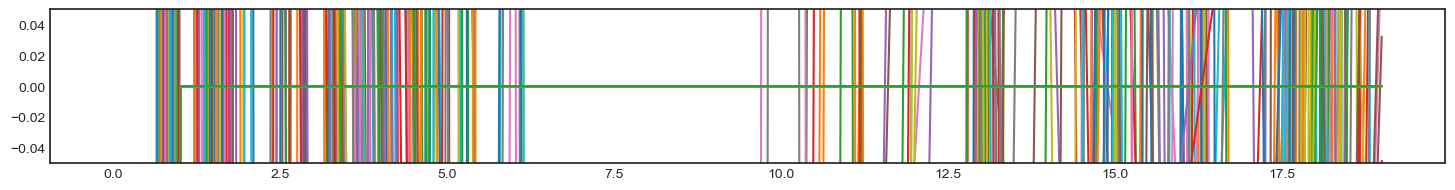

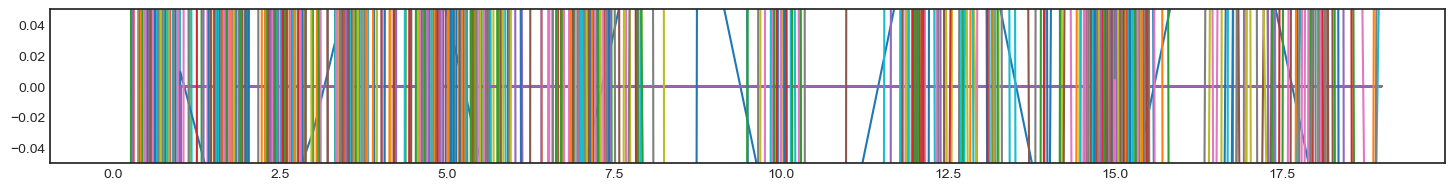

In [50]:
for idx in range(0, len(train_mfcc)):
    plt.figure(figsize=(18,2))
    plt.plot(train_mfcc[idx])
    plt.ylim((-0.05, 0.05))
    plt.show
    if idx==2: break

In [69]:
train_mfcc_np = np.array(train_mfcc, np.float32)
test_mfcc_np = np.array(test_mfcc, np.float32)

print(train_mfcc_np.shape, train_labels_np.shape)
print(test_mfcc_np.shape, test_labels_np.shape)

(11999, 20, 153) (11999,)
(1500, 20, 153) (1500,)


In [70]:
## convert 3dims to 2dims
train_mfcc_np = train_mfcc_np.reshape((11999, 20*153))
test_mfcc_np = test_mfcc_np.reshape(1500, 20*153)

print(train_mfcc_np.shape)
print(train_labels_np.shape)
print(test_mfcc_np.shape)
print(test_labels_np.shape)

(11999, 3060)
(11999,)
(1500, 3060)
(1500,)


## Machine Learning classification

### Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_mfcc_np, train_labels_np)
pred = LR.predict(test_mfcc_np)
acc = accuracy_score(pred, test_labels_np)
print(acc)

0.7926666666666666


C:\Users\USER\anaconda3\envs\kspeech4\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
y_test = test_labels_np
preds_list = pred
cf_matrix = confusion_matrix(y_test, preds_list)
cf_matrix

array([[562,  54,  13],
       [ 54, 401,  70],
       [ 14, 106, 226]], dtype=int64)

## Support Vector Machine

In [73]:
from sklearn import svm
SVM = svm.SVC(kernel='linear')
SVM.fit(train_mfcc_np, train_labels_np)
pred = SVM.predict(test_mfcc_np)
acc = accuracy_score(pred, test_labels_np)
print(acc)

0.716


In [74]:
# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
y_test = test_labels_np
preds_list = pred
cf_matrix = confusion_matrix(y_test, preds_list)
cf_matrix

array([[544,  75,  10],
       [ 85, 335, 105],
       [ 37, 114, 195]], dtype=int64)

## Decision Tree

In [75]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(train_mfcc_np, train_labels_np)
pred = DT.predict(test_mfcc_np)
acc = accuracy_score(pred, test_labels_np)
print(acc)

0.6193333333333333


In [76]:
# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
y_test = test_labels_np
preds_list = pred
cf_matrix = confusion_matrix(y_test, preds_list)
cf_matrix

array([[422, 160,  47],
       [127, 313,  85],
       [ 47, 105, 194]], dtype=int64)

## CNN classification

In [77]:
train_mfcc_np = np.array(train_mfcc, np.float32)
test_mfcc_np = np.array(test_mfcc, np.float32)

train_mfcc_array = np.expand_dims(train_mfcc_np, -1)
test_mfcc_array = np.expand_dims(test_mfcc_np, -1)

print(train_mfcc_array.shape)
print(train_labels.shape)
print(test_mfcc_array.shape)
print(test_labels.shape)

(11999, 20, 153, 1)
(11999,)
(1500, 20, 153, 1)
(1500,)


In [81]:
from keras.utils import to_categorical

train_labels_cat = to_categorical(train_labels_np)
test_labels_cat = to_categorical(test_labels_np)

print(train_labels_cat.shape)
print(test_labels_cat.shape)

(11999, 3)
(1500, 3)


In [82]:
train_labels_cat

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [90]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPool2D, Flatten

def CNN_model_build():
    model = Sequential()
    
    input = Input(shape=(20, 153, 1))
    output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
    output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)
    
    output = Flatten()(output)
    output=Dense(512, activation='relu')(output)
    output=Dense(256, activation='relu')(output)
    output=Dense(128, activation='relu')(output)
    
    output=Dense(3, activation='softmax')(output)
    
    model = Model(inputs=[input], outputs=output)
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['acc'])
    return model

In [91]:
CNN_model = CNN_model_build()
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 153, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 153, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 77, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 77, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 39, 256)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 39, 512)        118016

In [94]:
history = CNN_model.fit(train_mfcc_array, train_labels_cat, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
300/300 [==============================] - 106s 349ms/step - loss: 1.4922 - acc: 0.7399 - val_loss: 0.5182 - val_acc: 0.7837
Epoch 2/5
300/300 [==============================] - 105s 350ms/step - loss: 0.4242 - acc: 0.8221 - val_loss: 0.4782 - val_acc: 0.7892
Epoch 3/5
300/300 [==============================] - 105s 349ms/step - loss: 0.3798 - acc: 0.8366 - val_loss: 0.3948 - val_acc: 0.8283
Epoch 4/5
300/300 [==============================] - 106s 354ms/step - loss: 0.3262 - acc: 0.8624 - val_loss: 0.3692 - val_acc: 0.8487
Epoch 5/5
300/300 [==============================] - 105s 351ms/step - loss: 0.2802 - acc: 0.8859 - val_loss: 0.3938 - val_acc: 0.8487


In [95]:
def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss)+1)
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, loss, 'b--', label='train_loss')
    ax1.plot(epochs, val_loss, 'r', label='val_loss')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.legend()
    
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, acc, 'b--', label='train_accuracy')
    ax2.plot(epochs, val_acc, 'r', label='val_accuracy')
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("accuarcy")
    ax2.grid()
    ax2.legend()
    
    plt.show()

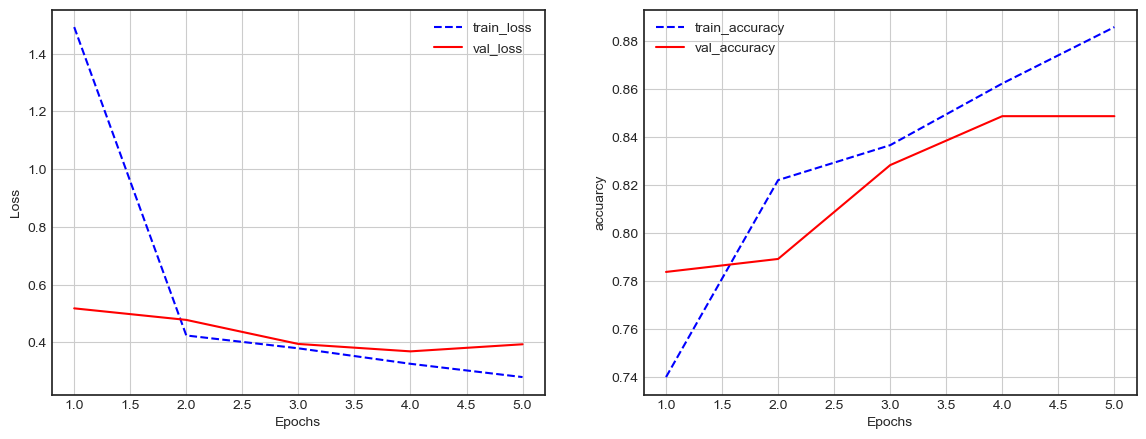

In [97]:
plot_history(history.history)

In [96]:
CNN_model.evaluate(test_mfcc_array, test_labels_cat)

47/47 [==============================] - 3s 64ms/step - loss: 0.4059 - acc: 0.8353


[0.4058719873428345, 0.8353333473205566]

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       629
           1       0.79      0.78      0.79       525
           2       0.76      0.71      0.73       346

    accuracy                           0.84      1500
   macro avg       0.82      0.81      0.82      1500
weighted avg       0.83      0.84      0.83      1500



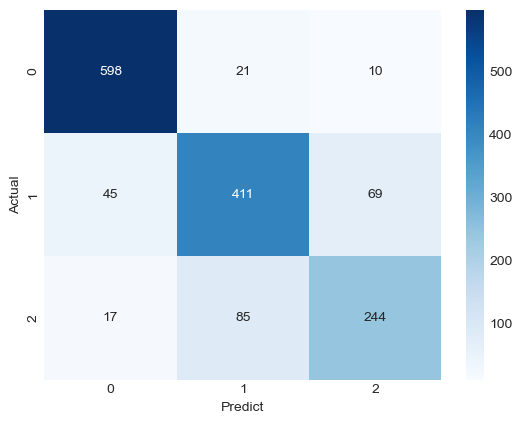

In [98]:
pred = CNN_model(test_mfcc_array)
## classification_report
from sklearn.metrics import classification_report
y_test = test_labels_np
preds_list = pred.numpy().argmax(-1)
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)
# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()